In [1]:
from typing import List
import torch
import torch.nn as nn
import torch.nn.functional as F

## 1. Data Preparation

### 1.1 Load data 

In [2]:
from datasets import load_dataset

dataset = load_dataset("conll2003")

In [3]:
dataset = dataset.remove_columns(["id", "pos_tags", "chunk_tags"])
dataset

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 3453
    })
})

In [4]:
dataset_train = dataset["train"]
dataset_val = dataset["validation"]
dataset_test = dataset["test"]

In [5]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
MAX_LEN = 113

In [6]:
from torch.utils.data import Dataset

class NER_Dataset(Dataset):
    def __init__(self, dataset, tokenizer):
        super().__init__()
        self.tokens = dataset["tokens"]
        self.labels = dataset["ner_tags"]
        self.tokenizer = tokenizer
        self.max_len = MAX_LEN

    def __len__(self):
        return len(self.tokens)
    
    def __getitem__(self, idx):
        input_token = self.tokens[idx]
        label_token = self.labels[idx]

        input_token = self.tokenizer.convert_tokens_to_ids(input_token)
        input_ids, labels = self.pad_and_truncate(input_token, label_token)

        return input_ids, labels
    
    def pad_and_truncate(self, sequence_token: List[int], sequence_label: List[int]): 
        pad_id = self.tokenizer.pad_token_id
        if len(sequence_token) < self.max_len:
            padded_sequence_token = sequence_token + [pad_id] * (self.max_len - len(sequence_token))
            padded_sequence_label = sequence_label + [0] * (self.max_len - len(sequence_label))
        else:
            padded_sequence_token = sequence_token[:self.max_len]
            padded_sequence_label = sequence_label[:self.max_len]
            
        return torch.tensor(padded_sequence_token), torch.tensor(padded_sequence_label)

In [7]:
train_set = NER_Dataset(dataset_train, tokenizer)
val_set = NER_Dataset(dataset_val, tokenizer)
test_set = NER_Dataset(dataset_test, tokenizer)

In [8]:
from torch.utils.data import DataLoader
batch_size = 512

train_loader = DataLoader(train_set, batch_size)
val_loader = DataLoader(val_set, batch_size)
test_loader = DataLoader(test_set, batch_size)

## 2. Model

In [9]:
import torch.nn.functional as F

class NER_Model(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_size, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.recurrent = nn.RNN(emb_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.recurrent(x)
        x = self.fc(x)
        return x.permute(0, 2, 1)

In [10]:
emb_dim = 256
hidden_size = 256
vocab_size = len(tokenizer)
num_classes = 9

model = NER_Model(vocab_size, emb_dim, hidden_size, num_classes)

In [11]:
from torchinfo import  summary

input_data = torch.randint(low=0, high=vocab_size-1, size=(512, MAX_LEN))
summary(model, input_data = input_data)

Layer (type:depth-idx)                   Output Shape              Param #
NER_Model                                [512, 9, 113]             --
├─Embedding: 1-1                         [512, 113, 256]           7,813,632
├─RNN: 1-2                               [512, 113, 256]           131,584
├─Linear: 1-3                            [512, 113, 9]             2,313
Total params: 7,947,529
Trainable params: 7,947,529
Non-trainable params: 0
Total mult-adds (G): 11.61
Input size (MB): 0.46
Forward/backward pass size (MB): 241.14
Params size (MB): 31.79
Estimated Total Size (MB): 273.40

## 3. Evaluate

In [12]:
def evaluate(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad(): 
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)

            total += (labels!=0).sum().item()
            test_loss += loss.item()
            correct += torch.multiply(predicted == labels, labels!=0).sum().item()

    test_loss = test_loss / len(test_loader)
    accuracy = 100* correct / total

    return test_loss, accuracy

## 4. Train model

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS = 50
LR = 1e-3
criterion = nn.CrossEntropyLoss(ignore_index=0)

In [14]:
def train_model(model):
    hist = {
        "train_loss": [],
        "train_accuracy": [],
        "val_loss": [],
        "val_accuracy": []
    }
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    model.to(device)
    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        running_correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += (labels!=0).sum().item()
            running_correct += torch.multiply(predicted == labels, labels!=0).sum().item()

            loss.backward()
            optimizer.step()

        epoch_loss =  running_loss / len(train_loader)
        epoch_accuracy = 100* running_correct / total
        val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)

        print(f"Epoch [{epoch + 1}/{EPOCHS}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Val loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        hist["train_loss"].append(epoch_loss)
        hist["train_accuracy"].append(epoch_accuracy)
        hist["val_loss"].append(val_loss)
        hist["val_accuracy"].append(val_accuracy)
    
    return hist

In [15]:
print(f"Training FC model")
hist = train_model(model)

Training FC model
Epoch [1/50], Loss: 1.5947, Accuracy: 37.87%, Val loss: 1.4932, Val Accuracy: 39.85%
Epoch [2/50], Loss: 1.4349, Accuracy: 43.73%, Val loss: 1.4410, Val Accuracy: 41.38%
Epoch [3/50], Loss: 1.3654, Accuracy: 47.03%, Val loss: 1.3986, Val Accuracy: 42.75%
Epoch [4/50], Loss: 1.3204, Accuracy: 48.83%, Val loss: 1.3609, Val Accuracy: 43.91%
Epoch [5/50], Loss: 1.2833, Accuracy: 50.19%, Val loss: 1.3371, Val Accuracy: 46.57%
Epoch [6/50], Loss: 1.2535, Accuracy: 51.52%, Val loss: 1.3197, Val Accuracy: 45.24%
Epoch [7/50], Loss: 1.2241, Accuracy: 52.49%, Val loss: 1.3043, Val Accuracy: 45.52%
Epoch [8/50], Loss: 1.1968, Accuracy: 52.32%, Val loss: 1.2938, Val Accuracy: 46.11%
Epoch [9/50], Loss: 1.1694, Accuracy: 54.54%, Val loss: 1.2845, Val Accuracy: 46.58%
Epoch [10/50], Loss: 1.1410, Accuracy: 55.25%, Val loss: 1.2794, Val Accuracy: 47.17%
Epoch [11/50], Loss: 1.1114, Accuracy: 57.20%, Val loss: 1.2785, Val Accuracy: 47.81%
Epoch [12/50], Loss: 1.0814, Accuracy: 58.67%

## 5. Plot results

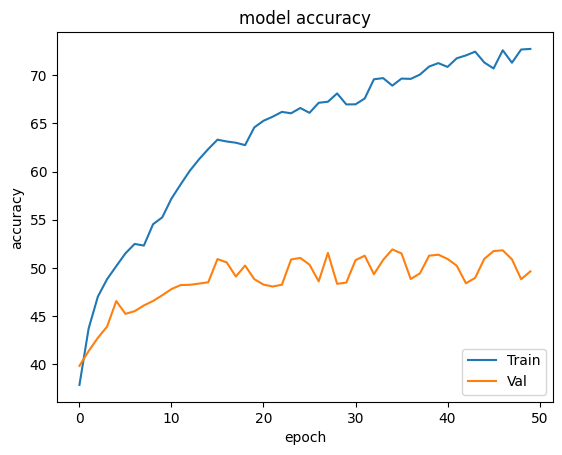

In [16]:
import matplotlib.pyplot as plt

plt.plot(hist['train_accuracy'], label='Train')
plt.plot(hist['val_accuracy'], label='Val')


plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val' ], loc='lower right')
plt.show()

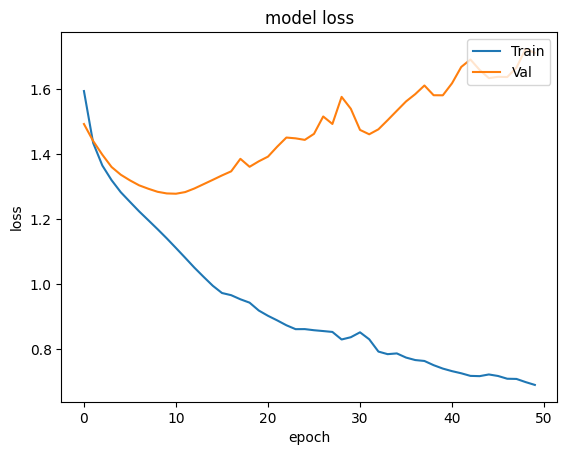

In [17]:
plt.plot(hist['train_loss'], label='Train')
plt.plot(hist['val_loss'], label='Val')


plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val' ], loc='upper right')
plt.show()